# Getting Started

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('../../')
os.getcwd()

'/teamspace/studios/this_studio/MAI_DUL_WS24'

In [2]:
# install latest version deepul package
!pip install -e .

Obtaining file:///teamspace/studios/this_studio/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///teamspace/studios/this_studio/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


In [3]:
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

In [4]:
ptu.set_gpu_mode(True)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train a GAN on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


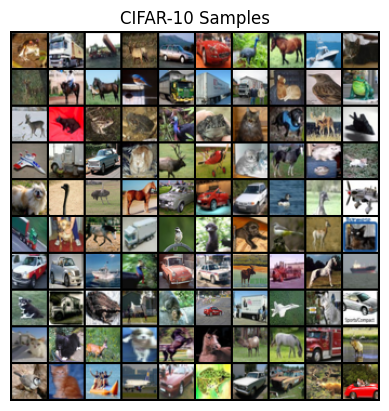

In [5]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf) (see page 17), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
The discriminator (no BatchNorm!).
```
def Discriminator(*):
    def __init__(self, n_filters=128):
        ResnetBlockDown(3, n_filters=n_filters),
        ResnetBlockDown(128, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        nn.ReLU()
        global sum pooling
        nn.Linear(128, 1)
```


**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

## Solution

 ### Models

In [6]:
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from homeworks.hw3.model import Generator, Discriminator
from tqdm.notebook import tqdm

In [7]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.reshape(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [8]:
def q2(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """
    torch.manual_seed(1)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() 
                         else "mps" if torch.backends.mps.is_available() 
                         else "cpu")
    print(f"Using device: {device}")

    # DataLoader settings based on device
    kwargs = {'num_workers': 8, 'pin_memory': True} if torch.cuda.is_available() else \
            {'num_workers': 8} if torch.backends.mps.is_available() else \
            {}

    # Hyperparameters
    batch_size = 256
    n_filters = 128
    n_critic = 5
    lambda_gp = 10
    n_epochs = 25
    lr = 2e-4
    
    # Convert data to torch tensors
    train_data = torch.FloatTensor(train_data)
    train_data = (train_data * 2) - 1  # Scale to [-1, 1]
    train_dataset = TensorDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)

    # Initialize models
    generator = Generator(n_filters=n_filters).to(device)
    discriminator = Discriminator(n_filters=n_filters).to(device)
    
    # Optimizers
    g_optimizer = Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    d_optimizer = Adam(discriminator.parameters(), lr=lr, betas=(0, 0.9))
    
    # Training loop
    losses = []
    total_steps = len(train_loader) * n_epochs
    step = 0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')
        pbar = tqdm(train_loader, unit='batch')

        for i, (real_imgs,) in enumerate(pbar):
            real_imgs = real_imgs.to(device)
            current_batch_size = real_imgs.size(0)

            # Train Discriminator
            for _ in range(n_critic):
                d_optimizer.zero_grad()
                
                z = torch.randn(current_batch_size, 128).to(device)
                fake_imgs = generator(z)
                
                real_validity = discriminator(real_imgs)
                fake_validity = discriminator(fake_imgs.detach())
                
                gradient_penalty = compute_gradient_penalty(discriminator, real_imgs, fake_imgs.detach(), device)
                
                d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
                d_loss.backward()
                d_optimizer.step()
                
                losses.append(d_loss.item())
            
            
            # Train Generator
            g_optimizer.zero_grad()
            
            gen_imgs = generator(z)
            gen_validity = discriminator(gen_imgs)
            g_loss = -torch.mean(gen_validity)
            
            g_loss.backward()
            g_optimizer.step()
            
            # Update learning rate
            step += 1
            lr_scale = max(0, 1 - step/total_steps)
            for param_group in g_optimizer.param_groups:
                param_group['lr'] = lr * lr_scale
            for param_group in d_optimizer.param_groups:
                param_group['lr'] = lr * lr_scale

            pbar.set_description(desc=f"discriminator_loss={d_loss:.4f}, generator_loss={g_loss:.4f}")
    
    # Generate samples
    generator.eval()
    with torch.no_grad():
        z = torch.randn(1000, 128).to(device)
        samples = generator(z)
        samples = (samples + 1) / 2  # Scale back to [0, 1]
        samples = samples.permute(0, 2, 3, 1).cpu().numpy()
    
    return np.array(losses), samples

## Results

Files already downloaded and verified
Using device: cuda
Epoch 1/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 2/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 3/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 4/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 5/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 6/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 7/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 8/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 9/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 10/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 11/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 12/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 13/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 14/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 15/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 16/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 17/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 18/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 19/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 20/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 21/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 22/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 23/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 24/25


  0%|          | 0/196 [00:00<?, ?batch/s]

Epoch 25/25


  0%|          | 0/196 [00:00<?, ?batch/s]

..........Inception score: 6.205696
FID Score: -1.428641489280868e+43


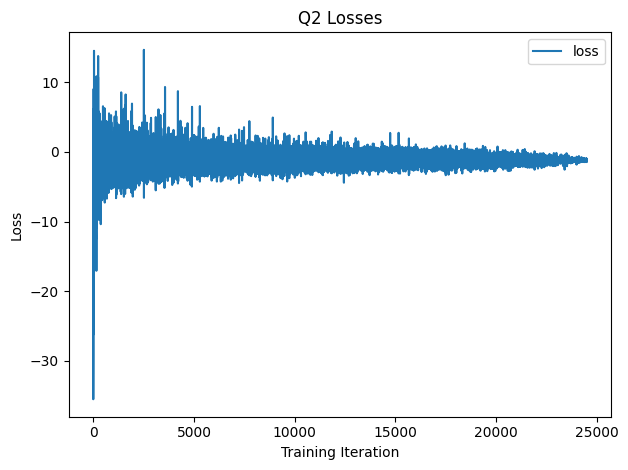

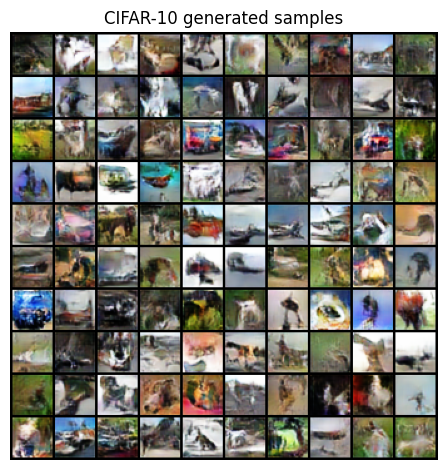

In [9]:
q2_save_results(q2)